# Swedish Property Market Analysis Notebook

This notebook contains an extensive analysis of the Swedish property market that allows for better purchase and sales decisions.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import numpy as np
import geopandas as gpd
import geoplot as gplt

In [2]:
con = sqlite3.connect('data/propertymarket.db')
closed_listings = pd.read_sql_query("select * from closed_listings", con)
geocoded = pd.read_sql_query("select * from geocoded", con)
closed_listings.shape

(5846, 23)

## Overview data

In [3]:
property_types = list(set(closed_listings['listing_type']))
property_types

['Par-/kedje-/radhus',
 'Kedjehus',
 'Parhus',
 'Vinterbonat fritidshus',
 'Lägenhet',
 'Radhus',
 'Villa',
 'Tomt',
 'Gård utan jordbruk',
 'Gård/skog',
 'Fritidsboende',
 'Gård med jordbruk',
 'Gård med skogsbruk',
 'Fritidshus']

<AxesSubplot:title={'center':'Transactions per listing type'}, ylabel='None'>

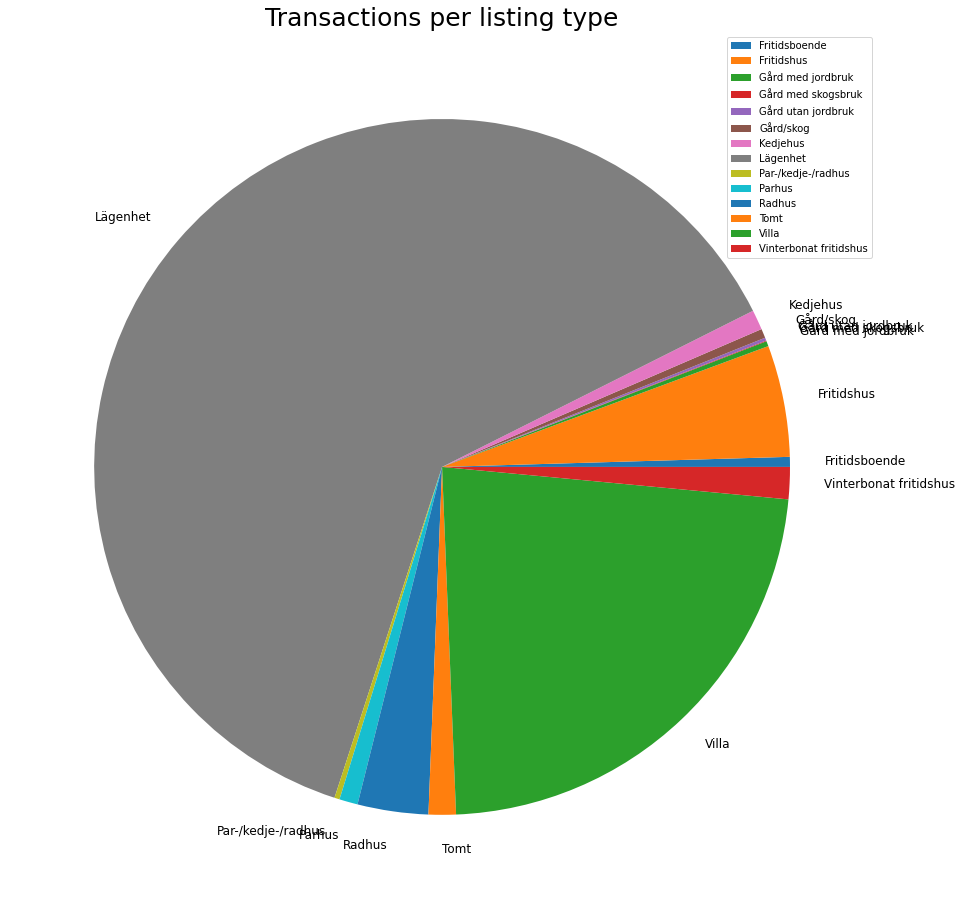

In [4]:
group = closed_listings.groupby('listing_type').size()
plt.axis('off')
plt.title('Transactions per listing type', fontsize=25)
group.plot.pie(subplots=False, figsize=(20,16), legend=True, fontsize=12)

[]

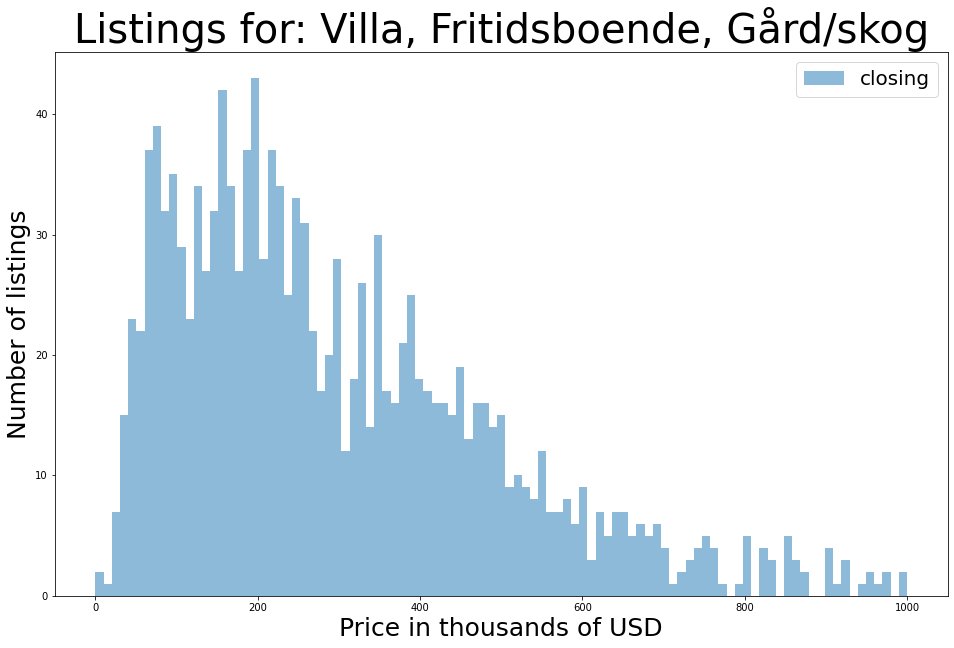

In [5]:
min_price = 0
max_price = 1e3
listing_types = ['Villa', 'Fritidsboende', 'Gård/skog']


bins = np.linspace(min_price, max_price, 100)
listings = closed_listings[closed_listings['listing_type'].isin(listing_types)]
plt.figure(figsize=(16,10))
plt.hist(listings['closing_price']/1e4, bins, alpha=0.5, label='closing')
plt.xlabel("Price in thousands of USD",fontsize=25)
plt.ylabel("Number of listings", fontsize=25)
plt.legend(loc='upper right', prop={'size': 20})
plt.title(f"Listings for: {', '.join(listing_types)}", fontsize=40)
plt.plot()

<AxesSubplot:title={'center':'Difference between closing and asking price in thousands of USD'}, ylabel='Frequency'>

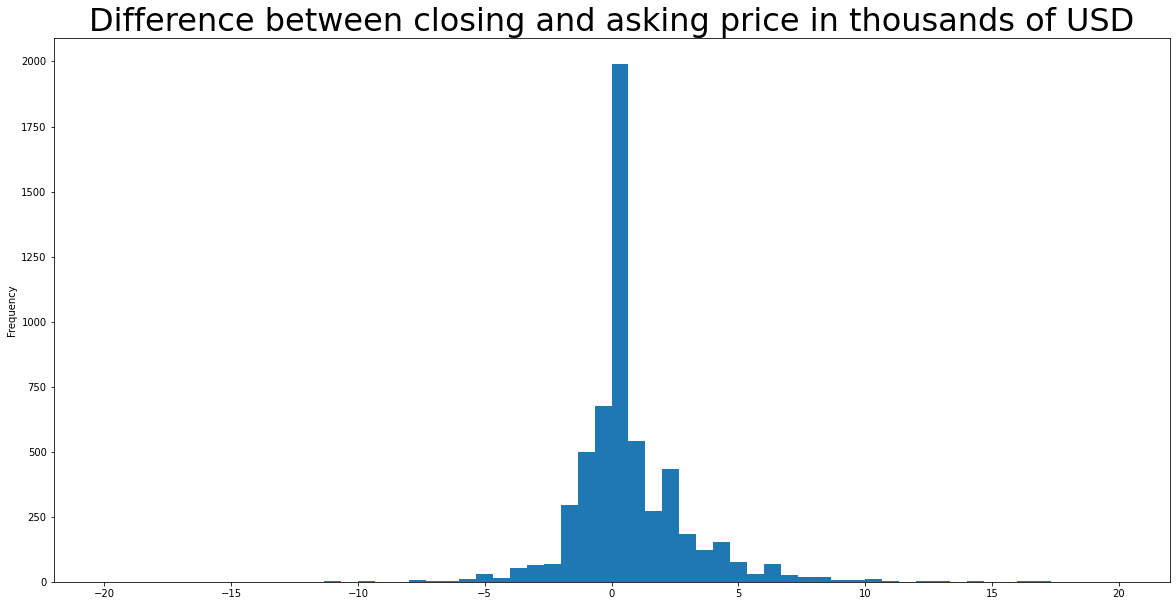

In [6]:
listings_with_asking_price = closed_listings[closed_listings['asking_price']!=-1]
plt.title('Difference between closing and asking price in thousands of USD', fontsize=32)
((listings_with_asking_price['closing_price']-listings_with_asking_price['asking_price'])/1e5).plot.hist(bins=60, figsize=(20,10), range=(-20,20))

[]

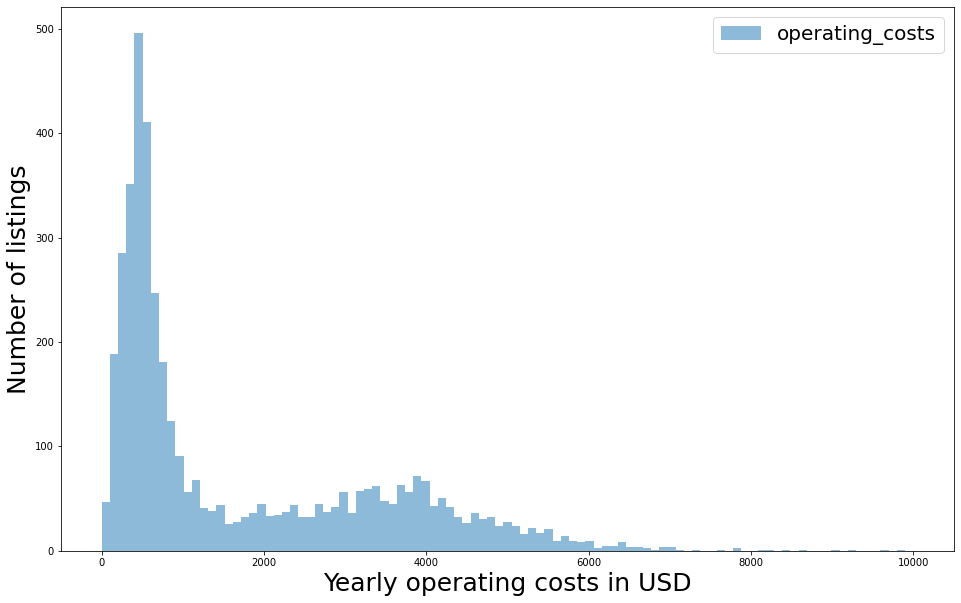

In [7]:
bins = np.linspace(0, 10000, 100)
plt.figure(figsize=(16,10))
plt.hist(closed_listings['operating_costs']/10*12, bins, alpha=0.5, label='operating_costs')
plt.xlabel("Yearly operating costs in USD",fontsize=25)
plt.ylabel("Number of listings", fontsize=25)
plt.legend(loc='upper right', prop={'size': 20})
plt.plot()

<GeoAxesSubplot:>

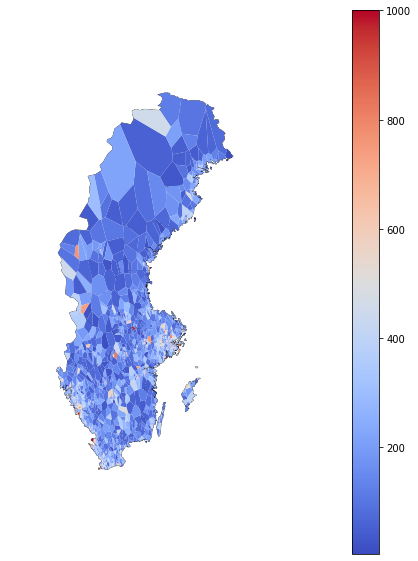

In [20]:
world = gpd.read_file("data/ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp")
swe = world[world['admin'] == 'Sweden']  # Filter out Sweden from the world
closed_listings_with_geo = pd.merge(closed_listings,geocoded, left_on='city', right_on='city')
df = closed_listings_with_geo.groupby('city').agg({'closing_price':'mean', 'lat':'min','lon':'min'})
df['closing_price'] /= 10000
df = df[df['closing_price']<=1000]
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))

proj = gplt.crs.AlbersEqualArea()
fig = plt.figure(figsize=(16,10))
ax1 = plt.subplot(121, projection=proj)
gplt.voronoi(gdf,
             cmap='coolwarm',
             clip=swe,
             hue="closing_price",
             legend=True,
             edgecolor="None",
             projection=proj,
             ax=ax1)
gplt.polyplot(swe, edgecolor="Black", zorder=1, linewidth=0.5, projection=proj, ax=ax1)